## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [42]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [43]:
df = pd.read_csv('ab_data.csv')

#inspect + check column headers
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [44]:
#first position is the row
df.shape[0]

294478

There are 5 rows in this data set.

c. The number of unique users in the dataset.

In [45]:
df['user_id'].nunique()

290584

The .nunique function returns the unique number of values for an object. There are 290,584 unique users.

d. The proportion of users converted.

In [46]:
#total number of users = 294478 // == num of rows
#converted is the fraction of users that have the 1 status of all rows
users_converted = sum(df['converted'].values)/294478
print('Proportion of converted users is :', users_converted)

Proportion of converted users is : 0.119659193556


e. The number of times the `new_page` and `treatment` don't line up.

In [47]:
#create new dataframe to find rows where landing page != new_page and group != treatment 
mismatch = df.query("(group == 'control' and landing_page == 'new_page') or (group == 'treatment' and landing_page == 'old_page')")

#print(mismatch.count()) to confirm all variables are consistent
print(mismatch.shape[0])


3893


The 'mismatch' is the number of times(rows) that new page and treatment do not line up. I first ran the count command and it return the number of rows across all variables. This is unneccessary, so instead I used the same .shape technique as used to find the number of rows.

f. Do any of the rows have missing values?

In [48]:
#get info for all variables to visually inspect
df.info
#sum the number of null values 
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There are no variables that have null values. However, if there were any nulls I would want to print those rows and column headers.

In [49]:
##print every row that has a null value
#null_columns=df.columns[df.isnull().any()]
#print(df[df.isnull().any(axis=1)][null_columns].head())

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [50]:
#create data frame that only includes rows where it is confirmed that landing_page and group align with test parameters
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [51]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [52]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [53]:
#find the dupe
dupe_uid = df2[df2.duplicated(['user_id'], keep=False)]
print(dupe_uid['user_id'])


1899    773192
2893    773192
Name: user_id, dtype: int64


c. What is the row information for the repeat **user_id**? 

In [54]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [55]:
#drop the duplicate row, keep the first record
df2 = df2.drop_duplicates(['user_id'], keep='first')

In [56]:
#confirm drop, userid should equal 290584
df2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [57]:
#Values for Converted are between 1 and 0. This allows us to use mean. We will use df2 as specified in directions
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [58]:
#use same code but drill down with control
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [59]:
#use same code but drill down with treatment
df2[df2['group'] == 'treatment']['converted'].mean()


0.11880806551510564

d. What is the probability that an individual received the new page?

In [60]:
#calculate number of individuals(rows) in df2 to divide
#individuals =df2.shape[0]
#calculate number of received new page

#calculate probability
len(df2.query("landing_page == 'new_page'")) / df2.shape[0]


0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

The probability of conversion in the treatment group and control group, respectively, is  0.118807 and 0.120386.
In this test, the old control group converts at a higher rate but by a very small margin.
Given this small margin and unaccounted for contextual factors such as change aversion there is no evidence that one page performs better than the other. Further, the probability of receiving the new page vs the old page is about .5. Therefore, the opportunities for each page were equivalent and did not influence the conversion rates negatively or positively.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}$ : $p_{old}$ >=  $p_{new}$
<br>
$H_{1}$ : $p_{old}$ <  $p_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [61]:
p_new  = df2['converted'].mean()
print(p_new)

0.119597087245


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [62]:
p_old = df2['converted'].mean()
print(p_old)

0.119597087245


c. What is $n_{new}$?

In [63]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
print(n_new)

145310


d. What is $n_{old}$?

In [64]:
n_old = df2[df2['group'] == 'control'].shape[0]
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [65]:
new_page_converted = np.random.binomial(n_new,p_new)
print(new_page_converted)

17373


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [66]:
old_page_converted = np.random.binomial(n_old,p_old)
print(old_page_converted)

17039


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [67]:
(new_page_converted/n_new) - (old_page_converted/n_old)

0.002269476336480697

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [68]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5,1,'Plot of 10,000 Test p_diffs')

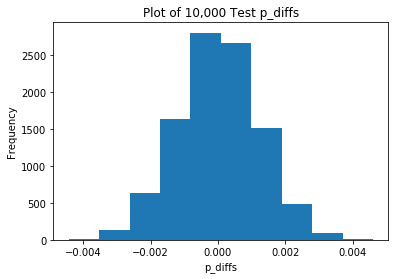

In [69]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Plot of 10,000 Test p_diffs')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [70]:
#calculate difference in ab_data.csv
actual_diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
print(actual_diff)
#proportion of p_diff greater than actual
(actual_diff < p_diffs).mean()

-0.00157823898536


0.90310000000000001

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The P-Value is used to quantify the statistical significance of evidence. Particularily, it is the probability of the null hypothesis being true. A large p-value(>.05) indicates that you cannot reject the null hypothesis. Therefore, a value of .9065 suggests that the null hypothesis cannot be rejected.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [71]:
import statsmodels.api as sm

convert_old = df2.query(" landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query(" landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]
#print convert_old, convert_new, n_old, n_new  #code to test if values generated correctly


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [72]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [73]:
from scipy.stats import norm
# How far out of standard deviation is the p value
print(norm.cdf(z_score))

#Critical value: use a single sided confidence interval to confirm that the old page is not better than the new page
print(norm.ppf(1-(0.05)))

0.905058312759
1.64485362695


The z-score (1.31092419842) is less than the critical value (1.64485362695). 
As regards the conversion rates of the old and new pages, we find that old pages are only slightly better than new pages and support the findings in sections (j) and (k).

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression- Categorical

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [74]:
df['intercept']=1
df[['control', 'treatment']] = pd.get_dummies(df['group'])

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [75]:
import statsmodels.api as sm
logit = sm.Logit(df['converted'],df[['intercept','treatment']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366243
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [76]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               294478
Model:                          Logit   Df Residuals:                   294476
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 May 2018   Pseudo R-squ.:               7.093e-06
Time:                        14:54:29   Log-Likelihood:            -1.0785e+05
converged:                       True   LL-Null:                   -1.0785e+05
                                        LLR p-value:                    0.2161
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9887      0.008   -248.297      0.000      -2.004      -1.973
treatment     -0.0140      0.011     -1.237      0.216      -0.036       0.008
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

$H_{0}$ : $p_{new}$ - $p_{old}$ = 0
$H_{1}$ : $p_{new}$ - $p_{old}$ != 0

In the Logistic regression we introduced two tailed test instead of the single tail in Part II. This additional dimension of testing for not equal can influence the p-value.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Other factors would improve results and give additional context for conversion. For example, if there was a measurement of returning status might be useful in understanding conversion behavior. Further, the device the user uses to navigate to the page may have an impact if the page is not optimized for mobile, for example. The Device can allow you to study conversion by Device Type.

However, with additional dimensions it can be difficult to accurate accomodate them. Many variables may be associated with each other which introduces confusion for correlation. Each additional variable leads to less clarity on the most impactful influences and small subsets work best.



g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [77]:
countriesdf = pd.read_csv('./countries.csv')
countriesdf.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [78]:
df3 = countriesdf.set_index('user_id').join(df2.set_index('user_id'), how='inner')
#confirm join in successful
df3.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0


In [79]:
#Create the necessary dummy variables
df3['intercept'] = 1
df3[['CA', 'US']] = pd.get_dummies(df3['country'])[['CA','US']]

df3['country'].astype(str).value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [80]:
#Fit Model
log_mod = sm.Logit(df3['converted'], df3[['CA', 'US']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.447174
         Iterations 6


In [81]:
#view results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 May 2018   Pseudo R-squ.:                 -0.2214
Time:                        14:54:30   Log-Likelihood:            -1.2994e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US            -1.9967      0.007   -292.314      0.000      -2.010      -1.983
==============================================================================
"""

This additional dimension does not push the results to reject the null hypothesis. This also indicates that the old landing page can be kept.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [82]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0